## Development of the Customer Risk Model
--- 

To train with TCN, simply go to the **TCN** section below, which is the third in this notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime 
import seaborn as sns


%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
import feather

%load_ext autoreload
%autoreload 2

In [3]:
import sys
import psutil
# utility functions
def memory_usage():
    print('total memory: {} GB'.format(psutil.virtual_memory()[0]/1000000000))
    print('available memory: {} GB'.format(psutil.virtual_memory()[1]/1000000000))
    print('used memory: {} GB'.format(psutil.virtual_memory()[3]/1000000000))
    print('free memory: {} GB'.format(psutil.virtual_memory()[4]/1000000000))
    print('active memory: {} GB'.format(psutil.virtual_memory()[5]/1000000000))
    print('inactive memory: {} GB'.format(psutil.virtual_memory()[6]/1000000000))
    print('buffers memory: {} GB'.format(psutil.virtual_memory()[7]/1000000000))
    print('cached memory: {} GB'.format(psutil.virtual_memory()[8]/1000000000))
    
def size_in_memory(df):
    print(df.shape)
    print('size in memory: {} MB'.format(sys.getsizeof(df)/1000000))
    return df

### Pulling Data
---

In [5]:
# customer level data
df = pd.read_csv('s3://sofi-data-science/tboser/customer-risk-data/2019-07-23-customer-risk-modeling-df.csv')

PermissionError: Forbidden

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097100 entries, 0 to 2097099
Data columns (total 48 columns):
user_id                               int64
borrower_id                           int64
reporting_date_id                     int64
account_closed_date                   object
account_closed_reason                 object
account_restricted_reason             object
date_of_birth                         object
fico_score                            float64
vantage_score                         float64
iqt9415                               float64
all7120                               float64
mtf5820                               float64
bcc7120                               float64
bcc2800                               float64
iln5520                               float64
bcx3423                               float64
use0300                               float64
use8220                               float64
stu5031                               float64
reporting_date         

In [63]:
# transactions level data
def query_dw(query):
    """
    Query sofidw.
    """
    engine = create_engine("postgres://127.0.0.1:15501/sofi_dw")
    _ = engine.connect()
    
    return pd.read_sql(query, engine)
    
query_t = '''
SELECT account_ending_balance,
       borrower_id,
       btf.banking_account_id,
       btf.banking_transaction_details_id,
       card_present_ind,
       international_transaction_flag, 
       transaction_created_date_id,
       time_of_day,
       transaction_amount,
       transaction_code,
       transaction_comment,
       transaction_type
FROM banking_transactions_facts btf
LEFT JOIN banking_transactions_details btd ON btf.banking_transaction_details_id=btd.banking_transaction_details_id
LEFT JOIN banking_accounts ba ON btf.banking_account_id = ba.banking_account_id
LEFT JOIN time_of_day tod on btf.transaction_created_time_id = tod.time_id
WHERE transaction_code IS NOT NULL
AND account_ending_balance IS NOT NULL
AND btd.active_flag = TRUE
AND btd.transaction_code NOT IN ('DIAD', 'IIAD', 'IIPD')
'''

%time transactions_df = query_dw(query_t)

CPU times: user 15.8 s, sys: 1.54 s, total: 17.4 s
Wall time: 24.6 s


In [64]:
df['reporting_date'] = pd.to_datetime(df['reporting_date'])

In [65]:
transactions_df_backup = transactions_df.copy()
df_backup = df.copy()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097100 entries, 0 to 2097099
Data columns (total 48 columns):
user_id                               int64
borrower_id                           int64
reporting_date_id                     int64
account_closed_date                   object
account_closed_reason                 object
account_restricted_reason             object
date_of_birth                         object
fico_score                            float64
vantage_score                         float64
iqt9415                               float64
all7120                               float64
mtf5820                               float64
bcc7120                               float64
bcc2800                               float64
iln5520                               float64
bcx3423                               float64
use0300                               float64
use8220                               float64
stu5031                               float64
reporting_date         

In [67]:
def drop_dup_transactions(df):
    df = df.dropna(subset=['transaction_code', 'account_ending_balance'])
    df = df.sort_values(by=['borrower_id', 'banking_account_id', 'banking_transaction_details_id'], ascending=False)
    df = df[~df.duplicated(subset=['banking_transaction_details_id'])]
    return df

transactions_df = drop_dup_transactions(transactions_df)
transactions_df['is_return'] = transactions_df['transaction_code'].isin(['DWACHRET', 'DWCKCB'])
transactions_df['is_chg_wrt_off'] = transactions_df['transaction_code'].isin(['DDCHGOFF', 'DDWRTOFF'])
transactions_df['time_of_day'] = transactions_df['time_of_day'].fillna('00:00:00').astype(str)
transactions_df['transaction_datetime'] = pd.to_datetime((transactions_df['transaction_created_date_id'].astype(str) + transactions_df['time_of_day'].astype(str)), format='%Y%m%d%H:%M:%S', errors='coerce')
transactions_df = transactions_df.sort_values(by=['transaction_datetime'])

In [68]:
# building features

#build transaction level features.
# num returns (cumsum)
transactions_df['nr_past_returns'] = transactions_df.groupby('borrower_id')['is_return'].cumsum()

# num transactions (cumcount)
transactions_df['nr_past_transactions'] = transactions_df.groupby('borrower_id')['borrower_id'].cumcount()

# info on transaction type
transactions_df['is_ach_deposit'] = transactions_df['transaction_code'] == 'ACHDD'
transactions_df['is_check_deposit'] = transactions_df['transaction_code'] == 'DDCK'
transactions_df['is_pos_transaction'] = transactions_df['transaction_code'].isin(['POSDW'])
transactions_df['is_atm_transaction'] = transactions_df['transaction_code'].isin(['DWATM', 'DDATMREFUND', 'DWATMI'])
transactions_df['nr_pos_transactions'] = transactions_df.groupby('borrower_id')['is_pos_transaction'].cumsum()
transactions_df['nr_atm_transactions'] = transactions_df.groupby('borrower_id')['is_atm_transaction'].cumsum()

# number of days since first transaction, transactions per day.
transactions_df = pd.merge(transactions_df, transactions_df.groupby('borrower_id')['transaction_datetime'].min().rename('first_transaction_datetime').to_frame(), on='borrower_id', how='left')
transactions_df['days_since_first_transaction'] = (transactions_df['transaction_datetime'] - transactions_df['first_transaction_datetime']).dt.days
transactions_df['nr_transactions_per_day'] = transactions_df['nr_past_transactions'] / transactions_df['days_since_first_transaction'].clip(lower=1)

# more individual transaction level info
transactions_df['transaction_as_pct_of_balance'] = transactions_df['transaction_amount'] / (transactions_df['account_ending_balance'] - transactions_df['transaction_amount'])
transactions_df.transaction_as_pct_of_balance.fillna(0, inplace=True)
transactions_df['is_dd'] = transactions_df['transaction_code'].isin(['ACHINDD'])
transactions_df['nr_direct_deposits'] = transactions_df.groupby('borrower_id')['is_dd'].cumsum()

transactions_df['transaction_as_pct_of_balance'] = transactions_df['transaction_as_pct_of_balance'].clip(-100, 100)

transactions_df = transactions_df.sort_values(by=['borrower_id', 'transaction_datetime'])
transactions_df['transaction_as_pct_of_bal_min'] = transactions_df.groupby('borrower_id')['transaction_as_pct_of_balance'].cummin()
transactions_df['transaction_as_pct_of_balance_abs'] = transactions_df['transaction_as_pct_of_balance'].abs()
transactions_df['rolling_trns_as_pct_of_bal'] = transactions_df.groupby('borrower_id').rolling('5d', on='transaction_datetime', min_periods=1)['transaction_as_pct_of_balance_abs'].mean().values
transactions_df['rolling_mean_acc_bal'] = transactions_df.groupby('borrower_id').rolling('7d', on='transaction_datetime', min_periods=1)['account_ending_balance'].mean().values


# miscellaneous
def space_str_filter(s):
    # return True if s is entirely composed of space or empty string else False
    return (''.join(s.split()) == '')

transactions_df['has_transaction_comment'] = transactions_df.transaction_comment.fillna('').apply(space_str_filter).astype(float)
transactions_df['card_present_ind'] = transactions_df['card_present_ind'].astype(float)
transactions_df['hr_of_transaction'] = transactions_df['time_of_day'].apply(lambda x: float(x.split(':')[0]))
transactions_df['international_transaction_flag'] = transactions_df['international_transaction_flag'].astype(float)

transactions_df = transactions_df.sort_values(by='transaction_datetime')

In [69]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357480 entries, 0 to 2357479
Data columns (total 35 columns):
account_ending_balance               float64
borrower_id                          int64
banking_account_id                   int64
banking_transaction_details_id       int64
card_present_ind                     float64
international_transaction_flag       float64
transaction_created_date_id          int64
time_of_day                          object
transaction_amount                   float64
transaction_code                     object
transaction_comment                  object
transaction_type                     object
is_return                            bool
is_chg_wrt_off                       bool
transaction_datetime                 datetime64[ns]
nr_past_returns                      float64
nr_past_transactions                 int64
is_ach_deposit                       bool
is_check_deposit                     bool
is_pos_transaction                   bool
is_atm_tr

In [70]:
# all transactions features
features_all = ['nr_past_returns', 'nr_past_transactions', 
                'nr_pos_transactions', 'nr_atm_transactions', 
                'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 
                'rolling_mean_acc_bal', 'nr_transactions_per_day', 
                'transaction_as_pct_of_bal_min', 'transaction_as_pct_of_balance',
                'card_present_ind', 'has_transaction_comment', 'hr_of_transaction', 
                'international_transaction_flag', 'days_since_first_transaction',
                'transaction_code', 'transaction_type']

# basic transactions features
features_basic = ['nr_past_transactions', 'card_present_ind', 'has_transaction_comment', 
                'hr_of_transaction', 'international_transaction_flag', 'transaction_code',
                'transaction_type', 'days_since_first_transaction',
                'transaction_as_pct_of_balance']

features_premium = list(set(features_all) - set(features_basic))

In [71]:
transactions_df.reset_index(drop=True).to_feather("../../data/TCN_CLF_customer_risk_score/v2/transactions_df.feather")
df.reset_index(drop=True).to_feather("../../data/TCN_CLF_customer_risk_score/v2/df.feather")
# %time transactions_df = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/transactions_df.feather")

#### Account level data
---

In [72]:
df['reporting_date'] = pd.to_datetime(df['reporting_date'])

In [73]:
# account level data
df_acct = pd.merge_asof(df[df.columns[~df.columns.isin(['transaction_datetime'])]], 
                        transactions_df[['borrower_id', 'transaction_datetime', 'card_present_ind', 'has_transaction_comment', 
                                         'hr_of_transaction', 'international_transaction_flag', 'transaction_code', 
                                         'transaction_type']], left_on='reporting_date', right_on='transaction_datetime', by='borrower_id')


df_acct['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df_acct['age'] = (pd.datetime.today() - df_acct['date_of_birth']).dt.days

modeling_df_acct = df_acct[~df_acct['latest_acc_bal'].isna() & ~df_acct['is_indeterminate']]
modeling_df_acct = modeling_df_acct.drop_duplicates(subset=['user_id', 'reporting_date_id'], keep='first')

#### Transaction level data
---

In [16]:
# all transactions features
features = ['nr_past_returns', 'nr_past_transactions', 
            'nr_pos_transactions', 'nr_atm_transactions', 
            'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 
            'rolling_mean_acc_bal', 'nr_transactions_per_day', 
            'transaction_as_pct_of_bal_min', 'transaction_as_pct_of_balance',
            'card_present_ind', 'has_transaction_comment', 'hr_of_transaction', 
            'international_transaction_flag', 'days_since_first_transaction',
            'transaction_code', 'transaction_type', 'transaction_description']

# basic transactions features
features = ['nr_past_transactions', 'card_present_ind', 'has_transaction_comment', 
            'hr_of_transaction', 'international_transaction_flag', 'transaction_code',
            'transaction_type', 'transaction_description', 'days_since_first_transaction',
            'transaction_as_pct_of_balance']

In [17]:
# merge transactions_df with df
# Notice, is_indeterminate came from df.
df['reporting_date_'] = df['reporting_date']
transactions_df_combined = pd.merge_asof(transactions_df, df[['num_transactions_all_time', 'user_id', 'borrower_id', 'target', 'latest_acc_bal', 'reporting_date', 'is_indeterminate']],
                                left_on='transaction_datetime', right_on='reporting_date', by='borrower_id', direction='forward')
transactions_df_combined = transactions_df_combined[~transactions_df_combined['latest_acc_bal'].isna()]
transactions_df_combined.is_indeterminate = transactions_df_combined.is_indeterminate.astype(bool)

# remove indeterminate rows
modeling_df_trans = transactions_df_combined[~transactions_df_combined['is_indeterminate']].copy()
modeling_df_trans['randf'] = np.random.randn(len(modeling_df_trans))
modeling_df_trans['index'] = range(len(modeling_df_trans))

# select columns to include
target=['target']
meta=['user_id', 'transaction_datetime', 'borrower_id', 'index', 'randf']

# all transactions features
features = ['nr_past_returns', 'nr_past_transactions', 
            'nr_pos_transactions', 'nr_atm_transactions', 
            'nr_direct_deposits', 'rolling_trns_as_pct_of_bal', 
            'rolling_mean_acc_bal', 'nr_transactions_per_day', 
            'transaction_as_pct_of_bal_min', 'transaction_as_pct_of_balance',
            'card_present_ind', 'has_transaction_comment', 'hr_of_transaction', 
            'international_transaction_flag', 'days_since_first_transaction',
            'transaction_code', 'transaction_type']
features = features + target + meta

modeling_df_trans = modeling_df_trans[features].copy()

# separate columns based on different types
types = modeling_df_trans.dtypes

features_cat = filter(lambda x: not np.issubdtype(x[1], np.number), types.iteritems())
features_cat = list(map(lambda x: x[0], features_cat))
features_num = sorted(list(set(features) - set(features_cat) - set(target) - set(meta)))
selected_features = features_num + features_cat + target + meta

# convert types to needed format
modeling_df_trans[['transaction_code', 'transaction_type']] = modeling_df_trans[['transaction_code', 'transaction_type']].fillna('')
modeling_df_trans[features_num] = modeling_df_trans[features_num].fillna(-1)
modeling_df_trans[features_num] = modeling_df_trans[features_num].astype(float)
modeling_df_trans.reset_index(drop=True, inplace=True)

#### `modeling_df_trans` & `modeling_df_acct` statistics and storage
---

In [74]:
modeling_df_trans.borrower_id.nunique(), modeling_df_acct.borrower_id.nunique()

(23308, 24158)

In [75]:
modeling_df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817174 entries, 0 to 817173
Data columns (total 23 columns):
nr_past_returns                   817174 non-null float64
nr_past_transactions              817174 non-null float64
nr_pos_transactions               817174 non-null float64
nr_atm_transactions               817174 non-null float64
nr_direct_deposits                817174 non-null float64
rolling_trns_as_pct_of_bal        817174 non-null float64
rolling_mean_acc_bal              817174 non-null float64
nr_transactions_per_day           817174 non-null float64
transaction_as_pct_of_bal_min     817174 non-null float64
transaction_as_pct_of_balance     817174 non-null float64
card_present_ind                  817174 non-null float64
has_transaction_comment           817174 non-null float64
hr_of_transaction                 817174 non-null float64
international_transaction_flag    817174 non-null float64
days_since_first_transaction      817174 non-null float64
transaction_code   

In [76]:
modeling_df_acct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096968 entries, 0 to 2097099
Data columns (total 54 columns):
user_id                               int64
borrower_id                           int64
reporting_date_id                     int64
account_closed_date                   object
account_closed_reason                 object
account_restricted_reason             object
date_of_birth                         datetime64[ns]
fico_score                            float64
vantage_score                         float64
iqt9415                               float64
all7120                               float64
mtf5820                               float64
bcc7120                               float64
bcc2800                               float64
iln5520                               float64
bcx3423                               float64
use0300                               float64
use8220                               float64
stu5031                               float64
reporting_date 

In [77]:
# saving splitting dataframes
modeling_df_trans.reset_index(drop=True).to_feather("data/TCN_CLF_customer_risk_score/v2/modeling_df_trans.feather")

# saving splitting dataframes
modeling_df_acct.reset_index(drop=True).to_feather("data/TCN_CLF_customer_risk_score/v2/modeling_df_acct.feather")

#### Train-test-split
---
Will use implemented splitter function in the TCN module

In [3]:
import TCNs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/sequential-models/TCN_v1'

In [7]:
modeling_df_trans = feather.read_dataframe("data/modeling_df_trans.feather")
modeling_df_acct = feather.read_dataframe("data/modeling_df_acct.feather")

## TCN
---

### OOF Validation

In [17]:
import os
import torch
import feather
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import TCNs
from utils import load_model
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load all data

In [18]:
modeling_df_trans = feather.read_dataframe("data/modeling_df_trans.feather")
modeling_df_acct = feather.read_dataframe("data/modeling_df_acct.feather")
modeling_dfs = torch.load("data/4fold_modeling_dfs.pth")
df_train_trans, df_test_trans = modeling_dfs[0]

In [3]:
# select features
target_col=['target']
meta_cols=['borrower_id', 'index']
features = ['nr_past_transactions', 'card_present_ind', 'has_transaction_comment', 
            'hr_of_transaction', 'international_transaction_flag', 'transaction_code',
            'transaction_type', 'days_since_first_transaction', 'transaction_as_pct_of_balance']


# modeling_df = modeling_df_trans[features + target_col + meta_cols].copy()
df_train = df_train_trans[features + target_col + meta_cols].copy()
df_test = df_test_trans[features + target_col + meta_cols].copy()

In [19]:
feature_embed_dims = {'transaction_code': 20,
                      'transaction_type': 10} 
pos_weight = len(df_train) / df_train.target.value_counts().loc[True]

model_dir = "models/model_dev"
tcn = TCNs.TCNClassifier(tcn_layers="200 200 200", 
                         mlp_layers="200 200 100", 
                         epoch=6, 
                         kernel_size=5,
                         batch_size=32, 
                         device="cuda:0", 
                         dropout_mlp=0.5, 
                         dropout_tcn=0.2, 
                         feature_embed_dims=feature_embed_dims, 
                         patience=10, 
                         model_dir=model_dir,
                         lr=0.0002, 
                         print_freq=300,
                         lr_decay_freq=3, 
                         weight_decay=1e-6,
                         log_path=os.path.join(model_dir, 'log.txt'), 
                         verbose=1,
                         min_length=1)

# for now, group_by only takes one item
print("\nprocessing data")
%time data = tcn.process_data(df_train, 'target', df_test, sort_by_col=['index'], group_by=['borrower_id'])
%time test_data = tcn.process_data_inference(df_test, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
print("\nfitting model")
%time tcn.fit(data)


processing data
data processed!
CPU times: user 46.9 s, sys: 112 ms, total: 47 s
Wall time: 47 s
data processed!
CPU times: user 12.1 s, sys: 75.6 ms, total: 12.2 s
Wall time: 12.2 s

fitting model
feature (transaction_code) vocabulary size: 47 
feature (transaction_type) vocabulary size: 13 
shuffling dataset:  True
num unknown tokens in test set:  0
train loader length: 547
params:  {'source_features': ['card_present_ind', 'days_since_first_transaction', 'has_transaction_comment', 'hr_of_transaction', 'international_transaction_flag', 'nr_past_transactions', 'transaction_as_pct_of_balance', 'transaction_code', 'transaction_type'], 'features_num': ['card_present_ind', 'days_since_first_transaction', 'has_transaction_comment', 'hr_of_transaction', 'international_transaction_flag', 'nr_past_transactions', 'transaction_as_pct_of_balance'], 'features_cat': ['transaction_code', 'transaction_type'], 'embed_dims': {'transaction_code': 20, 'transaction_type': 10}, 'vocab_lens': {'transaction

In [20]:
# load back the model saved at the early stopping iteration, to cpu
tcn = torch.load("models/model_dev/tcn.pth", map_location='cpu')

# process inference dataframe
test_data = tcn.process_data_inference(df_test, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])

# make predictions. 
# given a dataframe with multiple sequences, return predictions at all timesteps. 
preds = tcn.predict_proba(test_data, return_sequences=False)    

# given a dataframe with multiple sequences, return predictions at the last timestep.
preds_seq = tcn.predict_proba(test_data, return_sequences=True)

# join the preds dataframe with df_test based on the 'index' column
inference_pred = pd.merge(preds, df_test, on=['index'], how='inner')

# print the roc_auc score of the model prediction
print(roc_auc_score(y_true=inference_pred.target, y_score=inference_pred.tcn_pred))
inference_pred.head()

data processed!
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
0.978376825167699


,index,borrower_id_x,tcn_pred,nr_past_transactions,card_present_ind,has_transaction_comment,hr_of_transaction,international_transaction_flag,transaction_code,transaction_type,days_since_first_transaction,transaction_as_pct_of_balance,target,borrower_id_y
0,745591.0,550.0,0.001297,5.0,0.0,0.0,5.0,0.0,ACHDWIN,ACH,16.0,-0.000729,0.0,550
1,805044.0,1256.0,0.000595,68.0,0.0,0.0,6.0,0.0,ACHINDD,ACH,190.0,0.101140,0.0,1256
2,779753.0,3427.0,0.000147,75.0,0.0,0.0,6.0,0.0,ACHDWIN,ACH,138.0,-0.042332,0.0,3427
3,548861.0,3537.0,0.000011,8.0,0.0,0.0,18.0,0.0,ACHDD,ACH,91.0,0.142590,0.0,3537
4,394668.0,4821.0,0.000088,3.0,0.0,0.0,18.0,0.0,ACHDD,ACH,59.0,1.427572,0.0,4821


### OOT Validation
---


In [28]:
modeling_df_trans = feather.read_dataframe("data/modeling_df_trans.feather")
modeling_df_acct = feather.read_dataframe("data/modeling_df_acct.feather")

In [29]:
sep_date = datetime.datetime(2019, 5, 22)
df_train_oot = modeling_df_trans[modeling_df_trans.transaction_datetime < sep_date]
df_test_oot = modeling_df_trans[modeling_df_trans.transaction_datetime >= sep_date]
print(df_train_oot.shape, df_test_oot.shape)
print(1 / df_train_oot.target.value_counts(normalize=True).iloc[1], 1 / df_test_oot.target.value_counts(normalize=True).iloc[1])


(558623, 23) (258551, 23)
14.810122219571037 105.35900570497147


In [30]:
target_col=['target']
meta_cols=['borrower_id', 'index']
features = ['nr_past_transactions', 'card_present_ind', 'has_transaction_comment', 
            'hr_of_transaction', 'international_transaction_flag', 'transaction_code',
            'transaction_type', 'days_since_first_transaction', 'transaction_as_pct_of_balance']

In [31]:
df_train_oot = modeling_df_trans[modeling_df_trans.transaction_datetime < sep_date][features+target_col+meta_cols]
df_test_oot = modeling_df_trans[modeling_df_trans.transaction_datetime >= sep_date][features+target_col+meta_cols]
print("dataframe shapes: ")
print(df_train_oot.shape, df_test_oot.shape)
print(df_train_oot.info())

feature_embed_dims = {'transaction_code': 20,
                      'transaction_type': 10} 
pos_weight = len(df_train_oot) / df_train_oot.target.value_counts().loc[True]

model_dir = "models/model_oot_v1"
tcn = TCNs.TCNClassifier(tcn_layers="200 200 200", 
                         mlp_layers="200 200 100", 
                         epoch=10, 
                         kernel_size=5,
                         batch_size=32, 
                         device="cuda:0", 
                         dropout_mlp=0.5, 
                         dropout_tcn=0.2, 
                         feature_embed_dims=feature_embed_dims, 
                         patience=10, 
                         model_dir=model_dir,
                         lr=0.0002, 
                         print_freq=300,
                         lr_decay_freq=3, 
                         weight_decay=1e-6,
                         log_path=os.path.join(model_dir, 'log.txt'), 
                         verbose=1,
                         min_length=1)

# for now, group_by only takes one item
print("\nprocessing data")
%time data_oot = tcn.process_data(df_train_oot, 'target', df_test_oot, sort_by_col=['index'], group_by=['borrower_id'])
%time test_data_oot = tcn.process_data_inference(df_test_oot, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
print("\nfitting model")
%time tcn.fit(data_oot)

tcn_oot = torch.load("models/model_oot_v1/tcn.pth", map_location='cpu')
preds_oot = tcn.predict_proba(test_data_oot, return_sequences=True)
inference_pred_oot = pd.merge(preds_oot, df_test_oot, on=['index'], how='inner')
print(roc_auc_score(y_true=inference_pred_oot.target, y_score=inference_pred_oot.tcn_pred))
inference_pred_oot.head()

dataframe shapes: 
(558623, 12) (258551, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 558623 entries, 0 to 558622
Data columns (total 12 columns):
nr_past_transactions              558623 non-null float64
card_present_ind                  558623 non-null float64
has_transaction_comment           558623 non-null float64
hr_of_transaction                 558623 non-null float64
international_transaction_flag    558623 non-null float64
transaction_code                  558623 non-null object
transaction_type                  558623 non-null object
days_since_first_transaction      558623 non-null float64
transaction_as_pct_of_balance     558623 non-null float64
target                            558623 non-null bool
borrower_id                       558623 non-null int64
index                             558623 non-null int64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 51.7+ MB
None

processing data
data processed!
CPU times: user 1min 3s, sys: 53.7 ms, total: 1

,index,borrower_id_x,tcn_pred,nr_past_transactions,card_present_ind,has_transaction_comment,hr_of_transaction,international_transaction_flag,transaction_code,transaction_type,days_since_first_transaction,transaction_as_pct_of_balance,target,borrower_id_y
0,560140.0,90.0,0.001980,7.0,0.0,0.0,5.0,0.0,ACHDWIN,ACH,39.0,-0.038497,0.0,90
1,677300.0,90.0,0.000985,8.0,0.0,0.0,5.0,0.0,DPNC,OTHER,54.0,0.000000,0.0,90
2,697547.0,90.0,0.014712,10.0,1.0,0.0,14.0,0.0,DDATMREFUND,ATM,56.0,0.000248,0.0,90
3,697549.0,90.0,0.006341,9.0,1.0,0.0,14.0,0.0,DWATM,ATM,56.0,-0.032207,0.0,90
4,785208.0,90.0,0.003678,12.0,0.0,0.0,18.0,0.0,ACHDD,ACH,66.0,0.097831,0.0,90


In [43]:
# sep_date = datetime.datetime(2019, 5, 22)
# inference_pred_oot = feather.read_dataframe("data/tcn_pred_oot.feather")
# inference_pred_oot_valid = inference_pred_oot[inference_pred_oot.transaction_datetime < sep_date]
# print(inference_pred_oot_valid.shape)
# print(roc_auc_score(y_true=inference_pred_oot_valid.target, y_score=inference_pred_oot_valid.tcn_pred))

In [32]:
modeling_df_oot = modeling_df_trans[features+target_col+meta_cols]
inference_oot = tcn.process_data_inference(modeling_df_oot, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
tcn_preds_oot = tcn.predict_proba(inference_oot, return_sequences=True)
inference_pred_oot = pd.merge(tcn_preds_oot, modeling_df_trans, on=['index'], how='inner')
inference_pred_oot.reset_index(drop=True).to_feather("data/tcn_pred_oot.feather")

/home/ec2-user/SageMaker/sequential-models/TCN_v1/TCNs.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].astype(float)


data processed!
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False


In [44]:
print(roc_auc_score(y_true=inference_pred_oot.target, y_score=inference_pred_oot.tcn_pred))

0.9141373415146986


#### 4-fold cross validation on TCN
---

4-fold cross validation conducted on this task. Then we carried out validation and analysis with lgbm in the `customer_risk_model.ipynb` in the same directory.

In [13]:
from sklearn.model_selection import GroupKFold

def groupby_target_bal_kfold_train_test_split(df, k, seed=12345, groupby='user_id'):
    """
    This function takes in a dataframe, strategize by the targets, then conduct
    GroupKFold validation.
    
    @param df: dataframe
    @param k: number of folds
    @param seed: random seed for validation purpose
    @param groupby: the column to groupby in GroupKFold
    
    @returns dfs: dictionary of train, test dataframes with k being the fold number
    
    in the following format:
        keys: ints numbered with range(k)
        values: (train_df, test_df)
        
    Note: I was in rush...so instead of returning a more memory efficient object
    of a combined dataframe and the index of the respective folds, I returned
    a dictionary of (df_train, df_test), which is not adviced for future uses.
    """

    ############################################################
    #                   Train Test Split
    ############################################################

    df_true = df[df.target == True]
    df_false = df[df.target == False]
    random.seed(seed)

    grp1 = df_true[groupby]
    grp2 = df_false[groupby]
    n_splits = k
    groupkfold1 = GroupKFold(n_splits=n_splits)
    groupkfold2 = GroupKFold(n_splits=n_splits)
    
    true_folds = list(groupkfold1.split(df_true, groups = grp1))
    false_folds = list(groupkfold2.split(df_false, groups = grp2))
    dfs = {}
    for i in range(k):
        train_true, test_true = true_folds[i]
        train_false, test_false = false_folds[i]
        df_train = pd.concat([df_true.iloc[train_true], df_false.iloc[train_false]], axis=0)
        df_test = pd.concat([df_true.iloc[test_true], df_false.iloc[test_false]], axis=0)      
        print("overlapping bid counts: ", len(set(df_train.borrower_id.unique()).intersection(df_test.borrower_id.unique())))
        dfs[i] = (df_train, df_test)
    return dfs

In [14]:
modeling_dfs = groupby_target_bal_kfold_train_test_split(modeling_df, k=4, seed=12345, groupby='borrower_id')

overlapping bid counts:  0
overlapping bid counts:  0
overlapping bid counts:  0
overlapping bid counts:  0


In [15]:
dfs = []
modeling_dfs = groupby_target_bal_kfold_train_test_split(modeling_df, k=4, seed=12345, groupby='borrower_id')
for df_train, df_test in modeling_dfs.values():
    print("-" * 80)
    print(1/df_train.target.value_counts(normalize=True).loc[True])
    print(1/df_test.target.value_counts(normalize=True).loc[True])
    print(len(set(df_train.borrower_id.unique()).intersection(set(df_test.borrower_id.unique()))))

overlapping bid counts:  0
overlapping bid counts:  0
overlapping bid counts:  0
overlapping bid counts:  0
--------------------------------------------------------------------------------
20.34183013043911
20.3400039824771
0
--------------------------------------------------------------------------------
20.3412213740458
20.34183013043911
0
--------------------------------------------------------------------------------
20.3412213740458
20.34183013043911
0
--------------------------------------------------------------------------------
20.3412213740458
20.34183013043911
0


In [22]:
def tcn_k_fold_validation(modeling_dfs, seed=12345, epoch=10):
    """
    after producing the dictionary of (train_df, test_df) with groupby_target_bal_kfold_train_test_split,
    for (df_train, df_test) in each fold:
        train tcn on df_train
        evaluate on df_test
        
    return the models trained along with all of the predictions.
    The concatnated valid_preds is a dataframe consisting all available data
    with its corresponding validation tcn predictions, which can be used for
    future work without data leakage.
    
    @param modeling_dfs: dictionary of (train_df, test_df)
    @param seed: random seed for reproducing validation purpose
    @param epoch: number of epochs to train with given hyperparameter setup
    
    @return models: list of models trained.
    @return valid_pred: list of dataframes containing validation predictions,
                which concatnated contains tcn_pred for all available data without
                the risk of data leakage.
    """
    
    print("check split results: ")
    for df_train, df_test in modeling_dfs.values():
        print("-" * 80)
        print(1/df_train.target.value_counts(normalize=True).loc[True])
        print(1/df_test.target.value_counts(normalize=True).loc[True])
        print("overlapping bids between train and test: ")
        print(len(set(df_train.borrower_id.unique()).intersection(df_test.borrower_id.unique())))

    random.seed(seed)
    valid_preds = {}
    models = {}
    for i, (df_train, df_test) in modeling_dfs.items():
        print("\n\n--------------- new iteration! ---------------")
        feature_embed_dims = {'transaction_code': 20,
                          'transaction_type': 10} 
        pos_weight = len(df_train) / df_train.target.value_counts().loc[True]

        model_dir = "../model/TCN_CLF_TRANS_dev/"
        tcn = TCNs.TCNClassifier(tcn_layers="200 200 200", 
                                 mlp_layers="200 200 100", 
                                 epoch=epoch, 
                                 kernel_size=5,
                                 batch_size=32, 
                                 device="cuda:0", 
                                 dropout_mlp=0.5, 
                                 dropout_tcn=0.2, 
                                 feature_embed_dims=feature_embed_dims, 
                                 patience=10, 
                                 model_dir=model_dir,
                                 lr=0.0002, 
                                 print_freq=300,
                                 lr_decay_freq=3, 
                                 weight_decay=5e-4,
                                 log_path=os.path.join(model_dir, 'log.txt'), 
                                 verbose=1,
                                 min_length=1)

        print(df_train.info())
        data = tcn.process_data(df_train, 'target', df_test, sort_by_col=['index'], group_by=['borrower_id'])
        print("\nfitting model")
        tcn.fit(data)

        # load back the best performing iteration
        print("-" * 80)
        print("loading back best iter")
        tcn = torch.load(model_dir+"tcn.pth", map_location=lambda storage, loc: storage)
        models[i] = tcn
        tcn.set_params(device='cuda:0')
        print("processing inference data")
        test_data = tcn.process_data_inference(df_test, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
        preds = tcn.predict_proba(test_data, return_sequences=True)
        valid_preds[i] = preds
        
    return models, valid_preds


In [18]:
# load dataframe
modeling_df_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans.feather")

# setup features, meta columns, and target column
target_col=['target']
meta_cols=['borrower_id', 'index']
features = ['nr_past_transactions', 'card_present_ind', 'has_transaction_comment', 
            'hr_of_transaction', 'international_transaction_flag', 'transaction_code',
            'transaction_type', 'days_since_first_transaction', 'transaction_as_pct_of_balance']
modeling_df = modeling_df_trans[target_col+meta_cols+features]

# train-test-split and save
modeling_dfs = groupby_target_bal_kfold_train_test_split(modeling_df, k=4, seed=12345, groupby='borrower_id')
torch.save(modeling_dfs, "../data/TCN_CLF_customer_risk_score/v2/4fold_modeling_dfs.pth")

overlapping bid counts:  0
overlapping bid counts:  0
overlapping bid counts:  0
overlapping bid counts:  0


In [23]:
# k-fold validate on tcn and save the validation object to model dir
model_dir = "../model/TCN_CLF_TRANS_dev/"
models, valid_preds = tcn_k_fold_validation(modeling_dfs, seed=12345, epoch=10)
validation_object = {'models': models, 'valid_preds': valid_preds, "modeling_dfs": modeling_dfs}
torch.save(validation_object, model_dir+"validation_object.pth")

check split results: 
--------------------------------------------------------------------------------
20.34183013043911
20.3400039824771
overlapping bids between train and test: 
0
--------------------------------------------------------------------------------
20.3412213740458
20.34183013043911
overlapping bids between train and test: 
0
--------------------------------------------------------------------------------
20.3412213740458
20.34183013043911
overlapping bids between train and test: 
0
--------------------------------------------------------------------------------
20.3412213740458
20.34183013043911
overlapping bids between train and test: 
0


--------------- new iteration! ---------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 612879 entries, 251 to 817173
Data columns (total 12 columns):
target                            612879 non-null bool
borrower_id                       612879 non-null int64
index                             612879 non-null int64
nr_past_t

In [24]:
preds = pd.concat(list(valid_preds.values()))

In [32]:
preds.head()

,index,borrower_id,tcn_pred
0,600655.0,550.0,0.081643
1,728390.0,550.0,0.022906
2,739201.0,550.0,0.007916
3,745028.0,550.0,0.003492
4,745037.0,550.0,0.004104


In [25]:
four_fold_tcn_pred_df = pd.merge(preds, modeling_df_trans, on=['borrower_id', 'index'])

In [26]:
# get performance metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

def build_summary(target, pred, percentiles):
    """ cumulative """
    df = []
    target = pd.Series(np.array(target) == 1)
    pred = pd.Series(pred)
    for thresh, pctl in [(np.percentile(pred, pctl), pctl) for pctl in percentiles]:
        pred_tmp = pred >= thresh
        rep = classification_report(y_true=target, y_pred=pred_tmp, output_dict=True)
        conf = confusion_matrix(y_true=target, y_pred=pred_tmp)
        df.append([pctl, thresh, (1 - rep['True']['precision']) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[0][1], conf[1][0]])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', 
                                     '#Fraudulent Above Threshold', '#Good Above Threshold',
                                     '#Fraudulent Below Threshold'])


def plot_pr_curve(y_test, y_score):
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)
    
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP = {}'.format(str(average_precision)))
    

print("validation auc: ", roc_auc_score(four_fold_tcn_pred_df.target.astype(int), four_fold_tcn_pred_df.tcn_pred))
build_summary(four_fold_tcn_pred_df.target, four_fold_tcn_pred_df.tcn_pred, np.linspace(80, 100, 20, endpoint=False))

validation auc:  0.8920631055001426


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,80.0,0.047639,80.234344,80.412217,163435,32304,131131,7869
1,81.0,0.051622,79.472250,79.336868,155263,31872,123391,8301
2,82.0,0.056144,78.655535,78.151993,147092,31396,115696,8777
3,83.0,0.060911,77.705874,77.094068,138920,30971,107949,9202
4,84.0,0.066545,76.717043,75.777263,130748,30442,100306,9731
5,85.0,0.071858,75.575605,74.597366,122697,29968,92729,10205
6,86.0,0.078658,74.370875,72.986832,114405,29321,85084,10852
7,87.0,0.085346,73.062419,71.480845,106602,28716,77886,11457
8,88.0,0.091859,71.359664,69.910139,98061,28085,69976,12088
9,89.0,0.102586,69.677828,67.871456,89921,27266,62655,12907


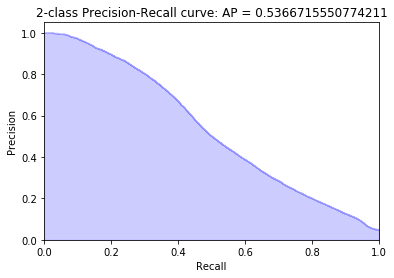

In [30]:
plot_pr_curve(four_fold_tcn_pred_df.target, four_fold_tcn_pred_df.tcn_pred)

In [31]:
four_fold_tcn_pred_df.to_feather("../data/TCN_CLF_customer_risk_score/v2/four_fold_tcn_pred_df.feather")

#### Inference
---

In [18]:
import TCNs

In [46]:
features = ['nr_past_transactions',
            'card_present_ind',
            'has_transaction_comment',
            'hr_of_transaction',
            'international_transaction_flag',
            'transaction_code',
            'transaction_type',
            'days_since_first_transaction',
            'transaction_as_pct_of_balance',
            'target',
            'borrower_id',
            'index']

modeling_df_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans.feather")
df_test = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/df_test_trans.feather")
modeling_df_trans = modeling_df_trans[features]
df_test = df_test[features]

In [55]:
# load and infer!
%time tcn = torch.load("../model/TCN_CLF_TRANS_basic_8/tcn.dill", map_location=lambda storage, loc: storage)
%time tcn.set_params(device='cuda:0')

# if infer on the test set
# %time test_data = tcn.process_data_inference(df_test, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])

# if infer on the full dataset
%time test_data = tcn.process_data_inference(modeling_df_trans, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
%time preds = tcn.predict_proba(test_data, return_sequences=True)

# merge with full dataset
modeling_df_trans = feather.read_dataframe("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans.feather")
inference_pred = pd.merge(preds, modeling_df_trans, on=['index', 'borrower_id'], how='inner')
inference_pred.head()

CPU times: user 21.3 ms, sys: 8.24 ms, total: 29.5 ms
Wall time: 28.4 ms
CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 13.4 µs
data processed!
CPU times: user 39.4 s, sys: 40.7 ms, total: 39.4 s
Wall time: 39.4 s
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
CPU times: user 30.9 s, sys: 9.24 s, total: 40.1 s
Wall time: 25 s


,index,borrower_id,tcn_pred,nr_past_returns,nr_past_transactions,nr_pos_transactions,nr_atm_transactions,nr_direct_deposits,rolling_trns_as_pct_of_bal,rolling_mean_acc_bal,...,has_transaction_comment,hr_of_transaction,international_transaction_flag,days_since_first_transaction,transaction_code,transaction_type,target,user_id,transaction_datetime,randf
0,288486.0,90.0,0.076686,0.0,0.0,0.0,0.0,0.0,100.000000,500.000000,...,0.0,18.0,0.0,0.0,ACHDD,ACH,False,273.0,2019-04-12 18:01:16,-1.328463
1,319444.0,90.0,0.030920,0.0,1.0,0.0,0.0,0.0,0.272727,3750.000000,...,0.0,18.0,0.0,5.0,ACHDD,ACH,False,273.0,2019-04-17 18:32:09,1.327231
2,319447.0,90.0,0.028697,0.0,2.0,0.0,0.0,0.0,5.136364,4333.333333,...,0.0,18.0,0.0,5.0,ACHDD,ACH,False,273.0,2019-04-17 18:32:09,-1.089058
3,377332.0,90.0,0.012303,0.0,3.0,0.0,0.0,0.0,0.928571,13500.000000,...,0.0,18.0,0.0,13.0,ACHDD,ACH,False,273.0,2019-04-26 18:01:08,0.102056
4,479867.0,90.0,0.005961,0.0,4.0,0.0,1.0,0.0,0.037237,13005.130000,...,0.0,18.0,0.0,28.0,DWATM,ATM,False,273.0,2019-05-10 18:27:41,0.461044


In [56]:
inference_pred.shape

(817174, 24)

In [57]:
inference_pred.to_feather("../data/TCN_CLF_customer_risk_score/v2/modeling_df_trans_w_tcn_pred.feather")

#### Performance: includes all returns

In [58]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [52]:
# get performance metrics

def build_summary(target, pred, percentiles):
    """ cumulative """
    df = []
    target = pd.Series(np.array(target) == 1)
    pred = pd.Series(pred)
    for thresh, pctl in [(np.percentile(pred, pctl), pctl) for pctl in percentiles]:
        pred_tmp = pred >= thresh
        rep = classification_report(y_true=target, y_pred=pred_tmp, output_dict=True)
        conf = confusion_matrix(y_true=target, y_pred=pred_tmp)
        df.append([pctl, thresh, (1 - rep['True']['precision']) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[0][1], conf[1][0]])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', 
                                     '#Fraudulent Above Threshold', '#Good Above Threshold',
                                     '#Fraudulent Below Threshold'])


def plot_pr_curve(y_test, y_score):
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_score)
    
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP = {}'.format(str(average_precision)))
    

print("validation auc: ", roc_auc_score(inference_pred.target.astype(int), inference_pred.tcn_pred))
build_summary(inference_pred.target, inference_pred.tcn_pred, np.linspace(80, 100, 20, endpoint=False))

validation auc:  0.9131791098849988


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,80.0,0.034555,78.906599,85.813855,163435,34474,128961,5699
1,81.0,0.037775,78.031907,84.972494,155389,34136,121253,6037
2,82.0,0.041899,77.043619,84.053967,147092,33767,113325,6406
3,83.0,0.046722,76.002735,82.983596,138920,33337,105583,6836
4,84.0,0.052236,74.881451,81.751425,130748,32842,97906,7331
5,85.0,0.057972,73.626158,80.471959,122576,32328,90248,7845
6,86.0,0.064451,72.242472,79.048117,114405,31756,82649,8417
7,87.0,0.072820,70.698371,77.484878,106233,31128,75105,9045
8,88.0,0.076686,70.083019,76.875016,103229,30883,72346,9290
9,89.0,0.086337,66.730448,74.443034,89890,29906,59984,10267


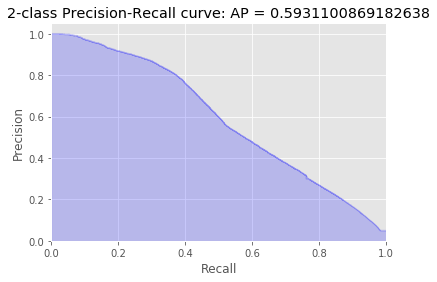

In [53]:
plot_pr_curve(inference_pred.target, inference_pred.tcn_pred)

#### Performance: catching first return

In [31]:
inference_pred['is_return'] = inference_pred['transaction_code'].isin(['DWACHRET', 'DWCKCB'])
inference_pred['nr_past_returns'] = inference_pred.groupby('borrower_id_x')['is_return'].cumsum()
inference_pred_first_return = inference_pred[inference_pred.nr_past_returns == 0]
print('auc for first returns: ', roc_auc_score(inference_pred_first_return.target.astype(int), inference_pred_first_return.tcn_pred))
build_summary(inference_pred_first_return.target, inference_pred_first_return.tcn_pred, np.linspace(80, 100, 20, endpoint=False))

auc for first returns:  0.9207777609379366


,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,80.0,0.027201,80.937910,86.214077,43437,8280,35157,1324
1,81.0,0.030143,80.276263,84.745939,41265,8139,33126,1465
2,82.0,0.033542,79.538536,83.288213,39093,7999,31094,1605
3,83.0,0.037388,78.678801,81.965848,36921,7872,29049,1732
4,84.0,0.041736,77.823822,80.237401,34749,7706,27043,1898
5,85.0,0.046676,76.916938,78.300708,32578,7520,25058,2084
6,86.0,0.052525,75.850161,76.457726,30406,7343,23063,2261
7,87.0,0.059583,74.835305,73.979592,28234,7105,21129,2499
8,88.0,0.067606,73.758729,71.209913,26062,6839,19223,2765
9,89.0,0.075528,72.565927,68.242399,23890,6554,17336,3050


#### Inference on one data point
---

#### Time taken to evaluate a single input sequence 

Return sequences

| sequence type | length | data processing time | inference time |
|---|---|---|---|
| long | 954 | 14 ms | 21.2 ms | 35.2 ms |
| medium | 61 | 9 ms | 22.1 ms | 31.1 ms |
| short | 8 | 8.6 ms | 22 ms | 30.6 ms |

Return single output

| sequence type | length | data processing time | inference time |
|---|---|---|---|
| long | 954 | 14 ms | 8.9 ms | 22.9 ms |
| medium | 61 | 9 ms | 8.2 ms | 17.2 ms |
| short | 8 | 8.6 ms | 8.4 ms | 17 ms |


In [71]:
# df_test_single = df_test[df_test.user_id.isin([13347986., 13187413.])] # SHORT
# df_test_single = df_test[df_test.user_id.isin([13173893., 13187413.])] # MEDIUM
# df_test_single = df_test[df_test.user_id.isin([13125453., 13144962.])] # LONG

df_test_single = df_test[df_test.borrower_id.isin([7162572, 7004010])] # SHORT
# df_test_single = df_test[df_test.borrower_id.isin([6990421, 7004010])] # MEDIUM
# df_test_single = df_test[df_test.borrower_id.isin([6939125, 6962038])] # LONG
df_test_single.head(100)

,nr_past_transactions,card_present_ind,has_transaction_comment,hr_of_transaction,international_transaction_flag,transaction_code,transaction_type,days_since_first_transaction,transaction_as_pct_of_balance,target,borrower_id,index
5103,0.0,0.0,0.0,14.0,0.0,ACHDD,ACH,0.0,100.000000,0.0,7004010,15912
19811,1.0,0.0,0.0,13.0,0.0,ACHDD,ACH,22.0,0.100000,0.0,7004010,62030
20893,2.0,0.0,0.0,9.0,0.0,ACHDD,ACH,23.0,0.400000,0.0,7004010,65221
42751,3.0,0.0,1.0,0.0,0.0,DWMBR,P2P,41.0,-0.035674,0.0,7004010,130410
44341,4.0,0.0,0.0,16.0,0.0,ACHDW,ACH,42.0,-0.090817,0.0,7004010,135075
45620,0.0,0.0,0.0,12.0,0.0,ACHDD,ACH,0.0,100.000000,0.0,7162572,138967
70190,1.0,0.0,0.0,13.0,0.0,ACHDD,ACH,15.0,0.249800,0.0,7162572,212052
74676,5.0,0.0,0.0,17.0,0.0,ACHDW,ACH,60.0,-0.295350,0.0,7004010,225498
112719,6.0,0.0,0.0,18.0,0.0,ACHDW,ACH,80.0,-0.209572,0.0,7004010,339039
125814,2.0,0.0,0.0,18.0,0.0,ACHDW,ACH,43.0,-0.498778,0.0,7162572,378372


In [64]:
feature_embed_dims = {'transaction_code': 20,
                      'transaction_type': 10} 

tcn = TCNs.TCNClassifier(tcn_layers='200 200 200', mlp_layers='200 100 50', epoch=6, kernel_size=4,
                    batch_size=32, device='gpu', dropout_mlp=0.5, dropout_tcn=0.1, 
                    model_dir='../model/TCN_CLF_TRANS_dev', feature_embed_dims=feature_embed_dims, 
                    patience=10, lr=0.0005, print_freq=300,
                    lr_decay_freq=3, log_path='../model/TCN_CLF_TRANS_dev/log.txt', verbose=1)

%time test_data = tcn.process_data(df_test, 'target', sort_by_col=['index'], group_by=['borrower_id'])
%time tcn.fit(test_data)

data processed!
CPU times: user 11.6 s, sys: 0 ns, total: 11.6 s
Wall time: 11.6 s
feature (transaction_code) vocabulary size: 44 
feature (transaction_type) vocabulary size: 13 
shuffling dataset:  True
train loader length: 220


 INITIALIZING A NEW MODEL 




saving vocabularies ... 
[epoch 1], train loss: 0.25929, train acc: 0.93114, train auc: 0.73019, time taken: 0.27 mins
current lr: [0.0005]
[epoch 2], train loss: 0.21701, train acc: 0.94499, train auc: 0.80795, time taken: 0.27 mins
current lr: [0.0005]
[epoch 3], train loss: 0.17949, train acc: 0.95073, train auc: 0.83967, time taken: 0.26 mins
current lr: [0.000125]
[epoch 4], train loss: 0.16436, train acc: 0.95245, train auc: 0.86181, time taken: 0.26 mins
current lr: [0.00025]
[epoch 5], train loss: 0.16624, train acc: 0.95346, train auc: 0.87165, time taken: 0.26 mins
current lr: [0.00025]
[epoch 6], train loss: 0.15480, train acc: 0.95520, train auc: 0.88593, time taken: 0.26 mins
current lr: [6.25e-05]
tot number of pos

In [72]:
# print("------------ time taken to evaluate one data point: ------------")
test_data_single = tcn.process_data_inference(df_test_single, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
preds_single = tcn.predict_proba(test_data_single, return_sequences=True)
inference_pred_single = pd.merge(preds_single, df_test_single, on=['index', 'borrower_id'], how='inner')
inference_pred_single[['index', 'borrower_id', 'tcn_pred', 'target']].head()

data processed!
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False


,index,borrower_id,tcn_pred,target
0,15912.0,7004010.0,0.192205,0.0
1,62030.0,7004010.0,0.013959,0.0
2,65221.0,7004010.0,0.011290,0.0
3,130410.0,7004010.0,0.014871,0.0
4,135075.0,7004010.0,0.006687,0.0


In [73]:
print("------------ time taken to evaluate one data point: ------------")
test_data_single = tcn.process_data_inference(df_test_single, target_col='target', sort_by_col=['index'], group_by=['borrower_id'])
preds_single = tcn.predict_proba(test_data_single, return_sequences=False)
print("-" * 80)
preds_single.head()

------------ time taken to evaluate one data point: ------------
data processed!
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
--------------------------------------------------------------------------------


,index,borrower_id,tcn_pred
0,601163.0,7004010.0,0.001085
1,616145.0,7162572.0,0.001454


### Interpretability
---

#### Embedding TSNE

In [78]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import copy
import nltk

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
tcn.model.embeds_transaction_code(torch.Tensor([1]).long().cuda()).cpu().detach().numpy().flatten()

array([ 0.9711916 , -1.3262161 , -0.0799214 ,  1.8608246 ,  0.52517265,
        1.0224566 , -0.07036651, -0.5696184 ,  1.2077919 ,  0.6393766 ,
        0.5102723 ,  0.95622927, -0.87373424,  0.22773582,  0.17759849,
       -0.78869134,  0.01344842,  3.5280278 , -0.22579195,  1.5896115 ],
      dtype=float32)

In [80]:
def tsne_plot(model, feature, device='cuda:0', perplexity=20, n_iter=2500, random_state=23):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

#     for word in model.wv.vocab:
#         tokens.append(model[word])
#         labels.append(word)
        
    vocab = copy.deepcopy(model.vocabs['w2i_dicts'][feature])
    embed = copy.deepcopy(getattr(model.model, 'embeds_'+feature))
    for word, index in vocab.items():
        tokens.append(embed(torch.Tensor([index]).long().to(device)).cpu().detach().numpy().flatten())
        labels.append(word)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=n_iter, random_state=random_state)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    plt.title("Feature: {}".format(feature))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

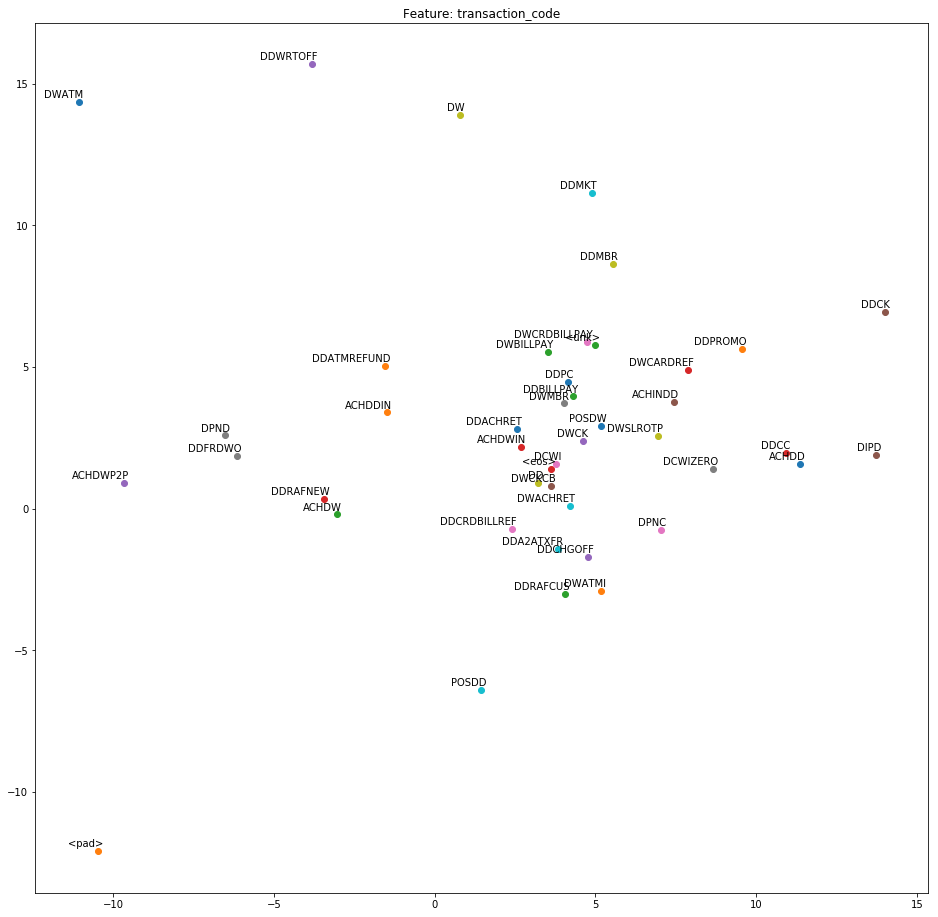

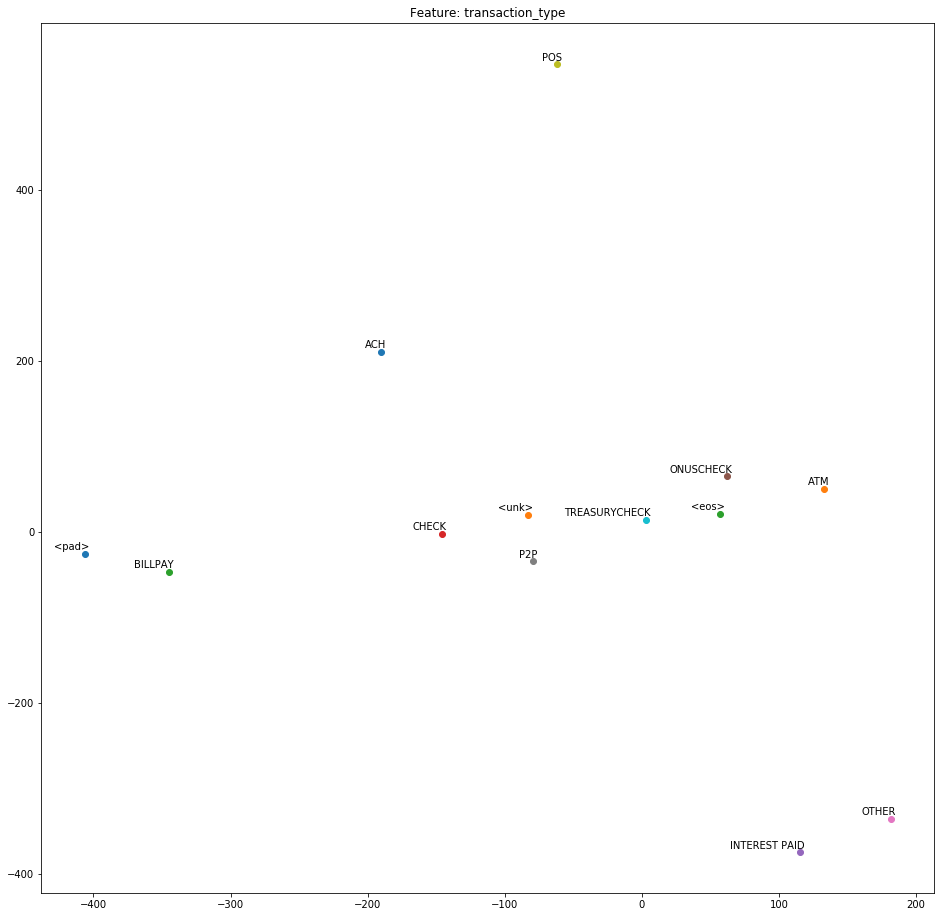

In [81]:
for feature in tcn.model.features_cat:
    tsne_plot(tcn, feature, perplexity=30, n_iter=250)